###Data Dictionary

* `customerID`: número de identificação único de cada cliente
* `Churn`: se o cliente deixou ou não a empresa
* `gender`: gênero (masculino ou feminino)
* `SeniorCitizen`: informaçãoo sobre um cliente ter ou não idade igual ou maior que 65 anos
* `Partner`:  se o cliente possui ou não um parceiro ou parceira
* `Dependents`: se o cliente possui ou não dependentes
* `tenure`:  meses de contrato do cliente
* `PhoneService`: assinatura de serviço telefonico
* `MultipleLines`: assinatura de mais de uma linha de telefone
* `InternetService`: assinatura de um provedor internet
* `OnlineSecurity`: assinatura adicional de segurança online
* `OnlineBackup`: assinatura adicional de backup online
* `DeviceProtection`: assinatura adicional de proteção no dispositivo
* `TechSupport`: assinatura adicional de suporte técnico, menos tempo de espera
* `StreamingTV`: assinatura de TV a cabo
* `StreamingMovies`: assinatura de streaming de filmes
* `Contract`: tipo de contrato
* `PaperlessBilling`: se o cliente prefere receber online a fatura
* `PaymentMethod`: forma de pagamento
* `Charges.Monthly`: total de todos os serviços do cliente por mês
* `Charges.Total`: total gasto pelo cliente

###Data extraction

In [ ]:
# import libraries and methods
import pandas as pd
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn import linear_model
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
# store the URL in url as & parameter for urlopen
url = "https://challenge-data-science-3ed.s3.amazonaws.com/Telco-Customer-Churn.json"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())

#transform list to df
df = pd.DataFrame(data_json)

#transform dicts in columns of df
new_column_1  = df['phone'].apply(pd.Series)
new_column_2  = df['customer'].apply(pd.Series)
new_column_3  = df['internet'].apply(pd.Series)
new_column_4  = df['account'].apply(pd.Series)

#transform dict in Charges column
df = pd.concat([df,new_column_1,new_column_2,new_column_3,new_column_4], axis=1)
df = pd.concat([df,df['Charges'].apply(pd.Series)], axis=1)

#drop old columns
df = df.drop(columns = ['phone','customer','internet','account','Charges'])

In [ ]:
#view all columns of data
pd.set_option('display.max_columns', None)
df.head()

,customerID,Churn,PhoneService,MultipleLines,gender,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total
0,0002-ORFBO,No,Yes,No,Female,0,Yes,Yes,9,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Yes,Yes,Male,0,No,No,9,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Yes,No,Male,0,No,No,4,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Yes,No,Male,1,Yes,No,13,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Yes,No,Female,1,Yes,No,3,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


### Outliers and Null Rows

In [ ]:
# If Exists missing data in churn variable, we will drop this registers
df = df[df['Churn'] != '']

# Drop registers that no get us information about churn
df = df[df['Churn'] != 'No phone service']

In [ ]:
# There no outliers values in numeric columns
print(df[(np.abs(stats.zscore(df['tenure'])) >= 3)].shape[0])
print(df[(np.abs(stats.zscore(df['Monthly'])) >= 3)].shape[0])

0
0


In [ ]:
#type of columns
df.dtypes

customerID           object
Churn                object
PhoneService         object
MultipleLines        object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Monthly             float64
Total                object
dtype: object

### Box- plots to Numerical Variables

<Axes: >

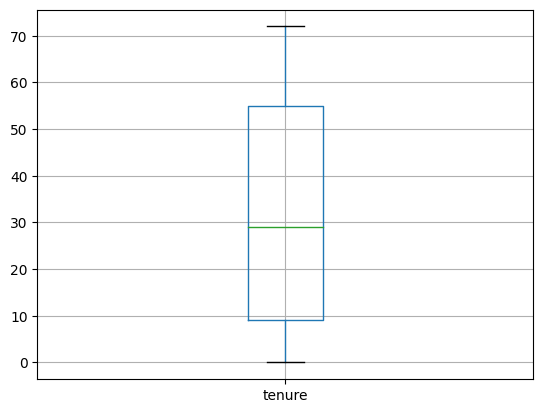

In [ ]:
#mean approx. 30 months, high variability
df.boxplot(column = 'tenure')


<Axes: >

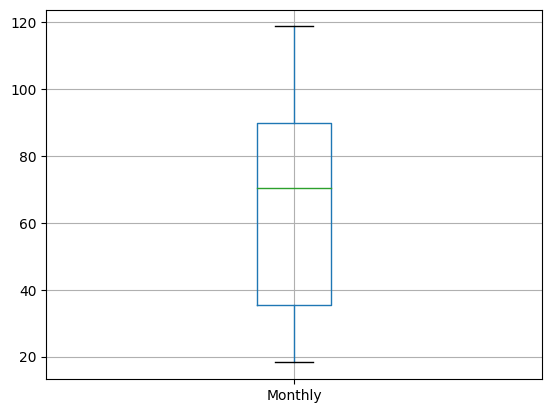

In [ ]:
#mean approx. 70, high variability too
df.boxplot(column = 'Monthly')

###Insights

In [ ]:
display(df[df['Churn'] == 'Yes'][['SeniorCitizen','tenure','Monthly']].describe())
display(df[df['Churn'] == 'No'][['SeniorCitizen','tenure','Monthly']].describe())
# Evidence that exists SeniorCitizen's influence in churn: more Seniors implies a NO CHURN
# Monthly: greater mean in CHURN

,SeniorCitizen,tenure,Monthly
count,1869.000000,1869.000000,1869.000000
mean,0.254682,17.979133,74.441332
std,0.435799,19.531123,24.666053
min,0.000000,1.000000,18.850000
25%,0.000000,2.000000,56.150000
50%,0.000000,10.000000,79.650000
75%,1.000000,29.000000,94.200000
max,1.000000,72.000000,118.350000


,SeniorCitizen,tenure,Monthly
count,5174.000000,5174.000000,5174.000000
mean,0.128721,37.569965,61.265124
std,0.334923,24.113777,31.092648
min,0.000000,0.000000,18.250000
25%,0.000000,15.000000,25.100000
50%,0.000000,38.000000,64.425000
75%,0.000000,61.000000,88.400000
max,1.000000,72.000000,118.750000


In [ ]:
display(df[df['Churn'] == 'No']['PhoneService'].value_counts(normalize=True) * 100)
display(df[df['Churn'] == 'Yes']['PhoneService'].value_counts(normalize=True) * 100)
# No evidence that PhoneService has influence in Churn

Yes    90.104368
No      9.895632
Name: PhoneService, dtype: float64

Yes    90.904227
No      9.095773
Name: PhoneService, dtype: float64

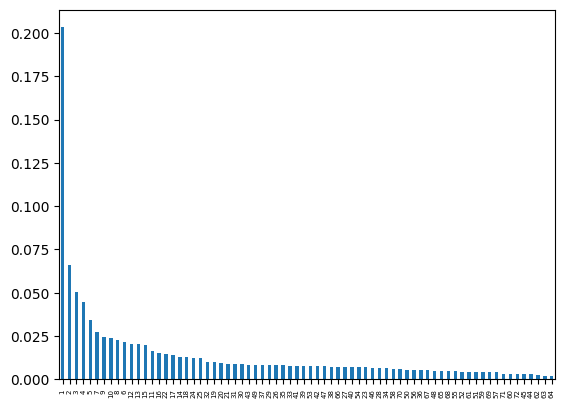

In [ ]:
df[df['Churn'] == 'Yes']['tenure'].value_counts(normalize = True).plot(kind = 'bar')
plt.xticks(fontsize=5)
plt.show()
# Greatest churn index in five first months of contract

In [ ]:
display(df[df['Churn'] == 'Yes']['PaymentMethod'].value_counts(normalize = True))
display(df[df['Churn'] == 'No']['PaymentMethod'].value_counts(normalize = True))

#Evidence: people had pays with electronic check has more churn, it's necessary investigate this payment method.

Electronic check             0.573034
Mailed check                 0.164794
Bank transfer (automatic)    0.138042
Credit card (automatic)      0.124131
Name: PaymentMethod, dtype: float64

Mailed check                 0.252029
Electronic check             0.250097
Credit card (automatic)      0.249324
Bank transfer (automatic)    0.248550
Name: PaymentMethod, dtype: float64

<Axes: title={'center': 'Sexo dos Clientes que estão na Novexus'}>

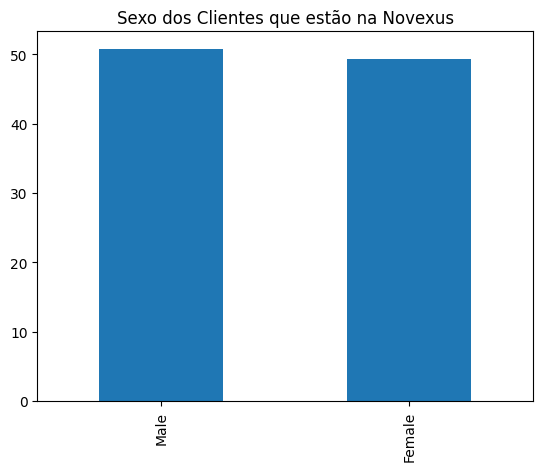

In [ ]:
(df[df['Churn'] == 'No']['gender'].value_counts(normalize=True)*100).plot(kind = 'bar',title = 'Sexo dos Clientes que estão na Novexus')


<Axes: title={'center': 'Sexo dos Clientes que abandonaram a Novexus'}>

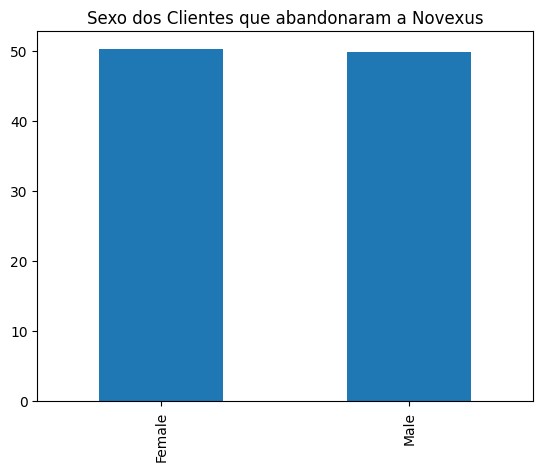

In [ ]:
(df[df['Churn'] == 'Yes']['gender'].value_counts(normalize=True)*100).plot(kind = 'bar',title = 'Sexo dos Clientes que abandonaram a Novexus')


<Axes: title={'center': 'Internet dos Clientes que estão na Novexus'}>

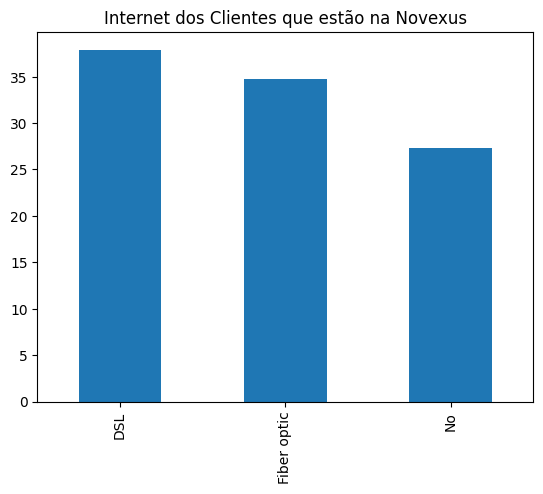

In [ ]:
(df[df['Churn'] == 'No']['InternetService'].value_counts(normalize=True)*100).plot(kind = 'bar',title = 'Internet dos Clientes que estão na Novexus')


<Axes: title={'center': 'Internet dos Clientes que abandonaram na Novexus'}>

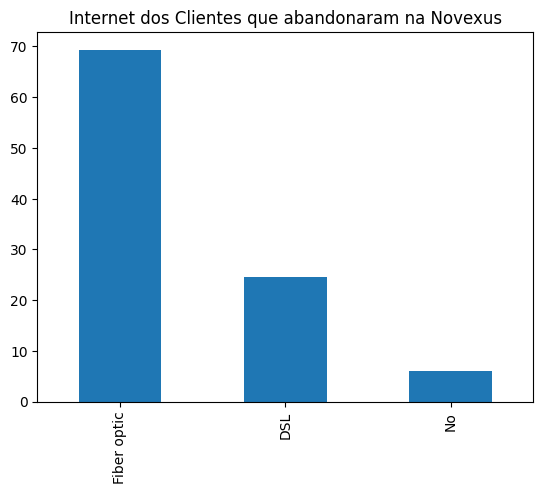

In [ ]:
(df[df['Churn'] == 'Yes']['InternetService'].value_counts(normalize=True)*100).plot(kind = 'bar',title = 'Internet dos Clientes que abandonaram na Novexus')
#Possible relationship with churn: internet type of fiber optic

<Axes: title={'center': 'Segurança Online dos Clientes que estão na Novexus'}>

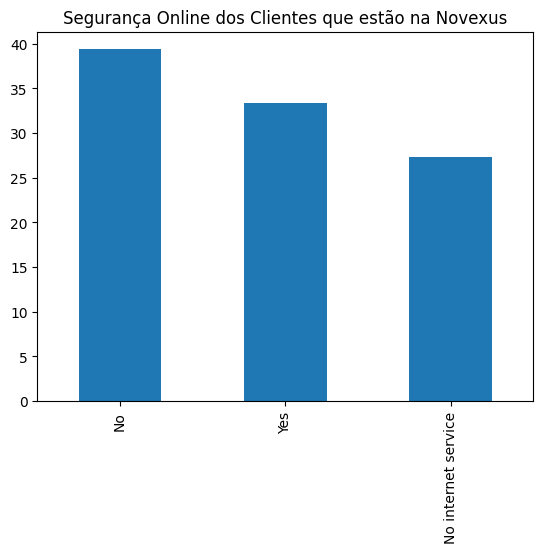

In [ ]:
(df[df['Churn'] == 'No']['OnlineSecurity'].value_counts(normalize=True)*100).plot(kind = 'bar',title = 'Segurança Online dos Clientes que estão na Novexus')



<Axes: title={'center': 'Segurança online dos Clientes que abandonaram na Novexus'}>

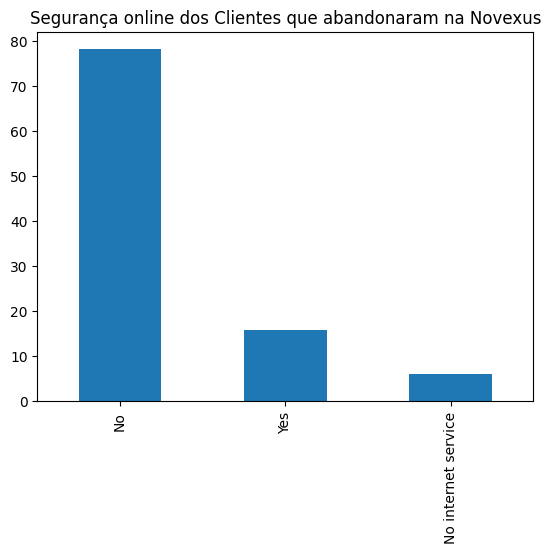

In [ ]:
(df[df['Churn'] == 'Yes']['OnlineSecurity'].value_counts(normalize=True)*100).plot(kind = 'bar',title = 'Segurança online dos Clientes que abandonaram na Novexus')
#Possible relationship with churn: No online security

<Axes: title={'center': 'Proteção de aparelho dos Clientes que estão na Novexus'}>

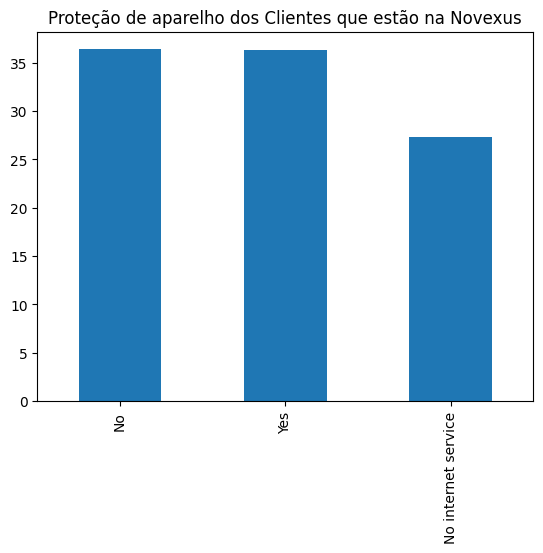

In [ ]:
(df[df['Churn'] == 'No']['DeviceProtection'].value_counts(normalize=True)*100).plot(kind = 'bar',title = 'Proteção de aparelho dos Clientes que estão na Novexus')

<Axes: title={'center': 'Proteção de aparelho dos Clientes que abandonaram a Novexus'}>

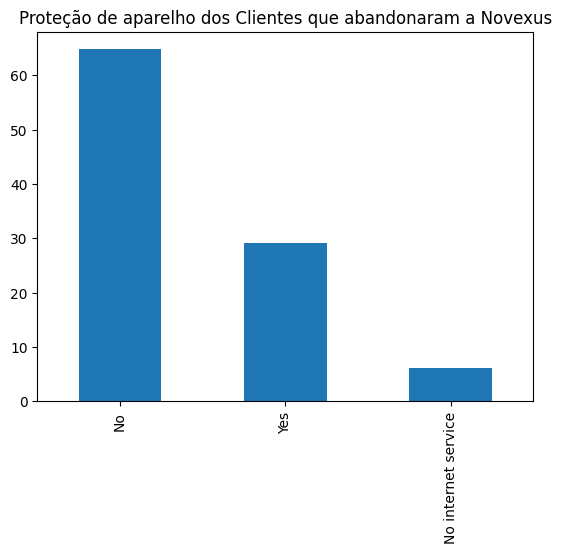

In [ ]:
(df[df['Churn'] == 'Yes']['DeviceProtection'].value_counts(normalize=True)*100).plot(kind = 'bar',title = 'Proteção de aparelho dos Clientes que abandonaram a Novexus')
# More difference in protection and no proctection option in clients that had a churn


In [ ]:
display(df[df['Churn'] == 'No']['Contract'].value_counts(normalize=True) * 100)
display(df[df['Churn'] == 'Yes']['Contract'].value_counts(normalize=True) * 100)
#Verify some improvements in month-to-month plan

Month-to-month    42.906842
Two year          31.832238
One year          25.260920
Name: Contract, dtype: float64

Month-to-month    88.550027
One year           8.881755
Two year           2.568218
Name: Contract, dtype: float64

### Correlation with variables by Chi Quadrado Test

In [ ]:
# Assumption(H0): The two columns are NOT related to each other

for i in df.columns:

  CrosstabResult=pd.crosstab(index = df['Churn'],columns = df[i])
  # Performing Chi-sq test
  ChiSqResult = chi2_contingency(CrosstabResult)

  # P-Value is the Probability of H0 being True
  # If P-Value&gt;0.05 then only we Accept the assumption(H0)

  if ChiSqResult[1] > 0.05: print(f'Variables Churn and {i} are not related to each other.')
  # else: print(f'Variables Churn and {i} are related to each other.')



Variables Churn and customerID are not related to each other.
Variables Churn and PhoneService are not related to each other.
Variables Churn and gender are not related to each other.
Variables Churn and Total are not related to each other.


In [ ]:
# exclude irrelevant variables to train the models
df_modelo = df.drop(['customerID', 'PhoneService','gender','Total'], axis=1)

### Data Enconding

In [ ]:
for i in df_modelo.columns:
  print(df_modelo[i].value_counts(normalize=True)*100)


No     73.463013
Yes    26.536987
Name: Churn, dtype: float64
No                  48.132898
Yes                 42.183729
No phone service     9.683374
Name: MultipleLines, dtype: float64
0    83.785319
1    16.214681
Name: SeniorCitizen, dtype: float64
No     51.69672
Yes    48.30328
Name: Partner, dtype: float64
No     70.041176
Yes    29.958824
Name: Dependents, dtype: float64
1     8.703677
72    5.139855
2     3.379242
3     2.839699
4     2.498935
        ...   
28    0.809314
39    0.795116
44    0.724123
36    0.709925
0     0.156183
Name: tenure, Length: 73, dtype: float64
Fiber optic    43.958540
DSL            34.374556
No             21.666903
Name: InternetService, dtype: float64
No                     49.666335
Yes                    28.666761
No internet service    21.666903
Name: OnlineSecurity, dtype: float64
No                     43.844952
Yes                    34.488144
No internet service    21.666903
Name: OnlineBackup, dtype: float64
No                     43.94

In [ ]:
# Transform columns in boolean type
df_modelo.replace(to_replace= 'DSL', value= 'Yes', regex=True, inplace = True)
df_modelo.replace(to_replace= 'Fiber optic', value= 'Yes', regex=True, inplace = True)
df_modelo.replace(to_replace = 'No phone service', value = 'No', inplace = True)
df_modelo.replace(to_replace = 'No internet service', value =  'No', inplace = True)

#get dummies in columns that have more of two types
df_modelo = pd.get_dummies(df_modelo, prefix = ['contract'], columns = ['Contract'])
df_modelo = pd.get_dummies(df_modelo, prefix = ['payment'], columns = ['PaymentMethod'])



###Normalize Numerical Variables

In [ ]:
#normalize two numerical columns
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_modelo[['tenure','Monthly']].to_numpy())

#normalized dataframe
df_scaled = pd.DataFrame(df_scaled, columns = ['tenure','Monthly'])

#drop old columns and concatenate the new columns
df_modelo = df_modelo.drop(columns = ['tenure','Monthly'], axis = 1)
df_normalized = pd.concat([df_modelo,df_scaled], axis=1, join="inner")


### Transform categorical variables in binaries


In [ ]:
categorical_columns = ["Churn","MultipleLines","Partner","Dependents","OnlineSecurity","OnlineBackup","DeviceProtection",
                       "TechSupport","StreamingTV","PaperlessBilling","StreamingMovies","InternetService"]

for i in categorical_columns:
  df_normalized[i] = pd.get_dummies(df_normalized[i])["Yes"]


In [ ]:
df_normalized

,Churn,MultipleLines,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,contract_Month-to-month,contract_One year,contract_Two year,payment_Bank transfer (automatic),payment_Credit card (automatic),payment_Electronic check,payment_Mailed check,tenure,Monthly
0,0,0,0,1,1,1,0,1,0,1,1,0,1,0,1,0,0,0,0,1,-0.951682,0.027862
1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,-0.951682,-0.161583
2,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,-1.155283,0.303720
3,1,0,1,1,0,1,0,1,1,0,1,1,1,1,0,0,0,0,1,0,-0.788800,1.104706
4,1,0,1,1,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,1,-1.196004,0.636080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,0,0,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,0,-0.788800,-0.319454
7039,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,-0.422317,0.675963
7040,0,1,1,1,0,1,1,1,0,0,1,0,1,1,0,0,0,0,1,0,-1.236724,-0.480648
7041,0,0,0,1,1,1,0,1,0,1,0,1,1,1,0,0,0,0,1,0,1.410099,0.102643


### Liding with unbalanced data

<Axes: title={'center': 'Proporção dos Dados: Variável Churn'}>

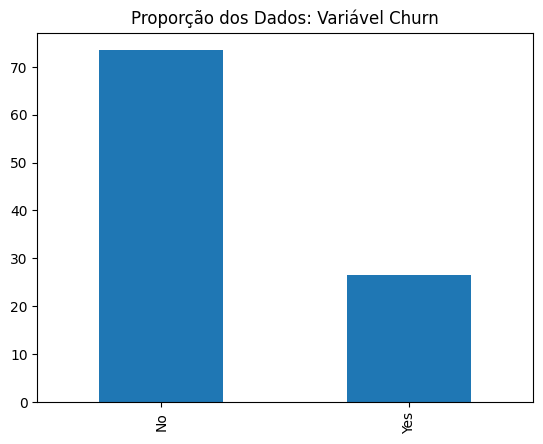

In [ ]:
(df['Churn'].value_counts(normalize=True)*100).plot(kind = 'bar',title = 'Proporção dos Dados: Variável Churn')
# churn is unbaleced

In [ ]:
#use oversampling to balanced data
X = df_normalized[['MultipleLines', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'contract_Month-to-month',
       'contract_One year', 'contract_Two year', 'PaperlessBilling', 'payment_Bank transfer (automatic)',
       'payment_Credit card (automatic)','payment_Electronic check', 'payment_Mailed check', 'tenure', 'Monthly']]

Y = df_normalized['Churn']

#use random over sampler
ros = RandomOverSampler(random_state=0)
X_resampled, Y_resampled = ros.fit_resample(X,Y)

#old data versus normalized data
print(Counter(Y))
print(Counter(Y_resampled))




Counter({0: 5009, 1: 1821})
Counter({0: 5009, 1: 5009})


In [ ]:
#dados que vamos utilizar em nossos modelos
df_normalized.columns

Index(['Churn', 'MultipleLines', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'contract_Month-to-month', 'contract_One year', 'contract_Two year',
       'payment_Bank transfer (automatic)', 'payment_Credit card (automatic)',
       'payment_Electronic check', 'payment_Mailed check', 'tenure',
       'Monthly'],
      dtype='object')


### Dummy Classifier

In [ ]:
#defines x,y data
x = df_normalized[['SeniorCitizen','Monthly','payment_Bank transfer (automatic)', 'payment_Credit card (automatic)',
       'payment_Electronic check','payment_Mailed check','InternetService','OnlineSecurity','DeviceProtection','Partner']]
y = df_normalized[['Churn']]

#numpy seed
SEED = 594094
np.random.seed(SEED)

#calls Dummy class
modelo = DummyClassifier(strategy='stratified')

#cross validate
results = cross_validate(modelo,x,y,cv = 10, return_train_score = False)

#confidence interval to accuracy
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()

#print
print("Accuracy com dummy stratified (cv = 10) = [%.2f,%.2f]" % (100*(media - 2*desvio_padrao),100*(media+2*desvio_padrao)))

Accuracy com dummy stratified (cv = 10) = [58.22,64.06]


###Naive-Bayes

In [ ]:
#random numpy
SEED = 52394920
np.random.seed(SEED)

#split train and test
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(raw_treino_x), len(raw_teste_x)))

#defines model
modelo = GaussianNB()
modelo.fit(raw_treino_x,treino_y)

#evaluates acurracy and f1 score
y_pred = modelo.predict(raw_teste_x)
acuracia = accuracy_score(y_pred, teste_y)
f1 = f1_score(y_pred,teste_y, average="weighted")

print("A acurácia foi %.2f%%" % (100*acuracia))
print("F1 Score: %.2f%%" % (100*f1))

Treinaremos com 5122 elementos e testaremos com 1708 elementos
A acurácia foi 73.89%
F1 Score: 73.30%


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Choose best Decision Tree Classifier's parameters with GridSearchCV

In [ ]:
SEED = 301
np.random.seed(SEED)

#defines the grid of the parameters
parameters_grid = {"max_depth": [i for i in range(1,6)],
                   "min_samples_leaf":[32*i for i in range(1,6)],
                   "min_samples_split":[32*i for i in range(1,6)],
                   "criterion":["gini","entropy"]}


#find the best parameters of tree decision classifier model
busca = GridSearchCV(estimator = DecisionTreeClassifier(),
                     param_grid = parameters_grid,
                     cv = KFold(n_splits = 5,shuffle = True))

#best paremeters
busca.fit(x,y)
resultados = pd.DataFrame(busca.cv_results_)
print('Best parameters:',busca.best_params_)
print('Best score:',busca.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 32}
Best score: 0.7535871156661786


###Implement Decision Tree Classifier

In [ ]:
SEED = 52394920
np.random.seed(SEED)
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(raw_treino_x), len(raw_teste_x)))

modelo = DecisionTreeClassifier(criterion = "gini",max_depth = 5, min_samples_leaf = 32, min_samples_split = 32)
modelo.fit(raw_treino_x, treino_y)
previsoes = modelo.predict(raw_teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)


Treinaremos com 5122 elementos e testaremos com 1708 elementos
A acurácia foi 75.94%


### Interface do Usuário

In [ ]:
#input your information in the dictionary
dictionary_input = {
 'SeniorCitizen': [0],
 'Monthly': [1.3],
 'payment_Bank transfer (automatic)': [0],
 'payment_Credit card (automatic)': [0],
 'payment_Electronic check': [1],
 'payment_Mailed check': [0],
 'InternetService': [1],
 'OnlineSecurity': [0],
 'DeviceProtection': [1],
 'Partner': [0]
 }

#predict of model
dataframe_input = pd.DataFrame(dictionary_input)
previsoes_input = modelo.predict(dataframe_input)